In [45]:
!pip install --pre --upgrade mxnet-cu90
!pip install gluoncv
!pip install gluonnlp
!pip install spacy
!pip install seaborn

Requirement already up-to-date: mxnet-cu90 in /home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (1.3.0b20180719)
Requirement not upgraded as not directly required: numpy<1.15.0,>=1.8.2 in /home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (from mxnet-cu90) (1.13.3)
Requirement not upgraded as not directly required: requests<2.19.0,>=2.18.4 in /home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (from mxnet-cu90) (2.18.4)
Requirement not upgraded as not directly required: graphviz<0.9.0,>=0.8.1 in /home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (from mxnet-cu90) (0.8.1)
Requirement not upgraded as not directly required: chardet<3.1.0,>=3.0.2 in /home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (from requests<2.19.0,>=2.18.4->mxnet-cu90) (3.0.4)
Requirement not upgraded as not directly required: idna<2.7,>=2.5 in /home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages (from requests<2.19.0,>=2.18.4->m

    100% |████████████████████████████████| 215kB 4.5MB/s ta 0:00:01
mxnet-model-server 0.3 requires fasteners, which is not installed.
mxnet-model-server 0.3 requires importlib2, which is not installed.
mxnet-model-server 0.3 requires mxnet>=1.1, which is not installed.
mxnet-model-server 0.3 requires onnx-mxnet>=0.4.2, which is not installed.


# Checking MXNet version after upgrade

In [98]:
import mxnet as mx
mx.__version__

'1.3.0'

# Import statemetns

In [99]:
from mxnet import gluon
import gluonnlp as nlp
import time
import multiprocessing as mp
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Downloading IMDB Data Set & Instansiating SimpleDataSet Objects

In [100]:
from numpy.random import randint
train_dataset = nlp.data.IMDB(segment='train', root='../data/')
test_dataset = nlp.data.IMDB(segment='test', root='../data/')
for i in range(10):
    print(train_dataset[randint(1, 20000)][1])

10
10
7
3
10
2
10
1
1
1


# SimpleDataset Class Hierarchy

In [109]:
print(nlp.data.IMDB.__bases__)
print(gluon.data.SimpleDataset.__bases__)

(<class 'mxnet.gluon.data.dataset.SimpleDataset'>,)
(<class 'mxnet.gluon.data.dataset.Dataset'>,)



# Setting Max Seq Length & Defining Tokenizer

In [103]:
length_clip = nlp.data.ClipSequence(500)
tokenizer = nlp.data.SpacyTokenizer('en')

# Pre-processing Data

- `preprocess(x)` 
 - normalized label to 1 for positive and 0 for negative
 - tokenized data
 - clips the length
 - returns tokenized data and label

- `preprocess_dataset` uses paralele processing using maximum number of CPUs to
 - run `preprocess`, and
 - calculate length of each sentence

In [104]:
# Dataset preprocessing
def preprocess(x):
    data = x[0]
    label = x[1]
    label = int(label > 5)
    data = length_clip(tokenizer(data))
    return data, label

def get_length(x):
    return float(len(x[0]))

def preprocess_dataset(dataset):
    start = time.time()
    pool = mp.Pool()
    dataset = gluon.data.SimpleDataset(pool.map(preprocess, dataset))
    lengths = gluon.data.SimpleDataset(pool.map(get_length, dataset))
    end = time.time()
    print('Done! Tokenizing Time={:.2f}s, #Sentences={}'.format(end - start, len(dataset)))
    return dataset, lengths

# Preprocess the dataset
train_dataset, train_data_lengths = preprocess_dataset(train_dataset)
test_dataset, test_data_lengths = preprocess_dataset(test_dataset)


Done! Tokenizing Time=6.29s, #Sentences=25000
Done! Tokenizing Time=6.04s, #Sentences=25000


In [105]:
train_seqs = [sample[0] for sample in train_dataset]
counter = nlp.data.count_tokens(list(itertools.chain.from_iterable(train_seqs)))
vocab = nlp.Vocab(counter=counter, max_size=10000, padding_token=None, eos_token=None, bos_token=None)


In [106]:
def t2i(x):
    return vocab[x[0]], x[1]

pool = mp.Pool()
train_dataset = pool.map(t2i, train_dataset)
test_dataset = pool.map(t2i, test_dataset)
pool.close()
print("sentence0: {}\nlength of sentence0: {}\n".format(train_dataset[0][0][:], train_data_lengths[0]))
print("sentence1: {}\nlength of sentence1: {}\n".format(train_dataset[1][0][:], train_data_lengths[1]))


sentence0: [0, 2012, 8, 4, 1116, 231, 3, 51, 2311, 40, 1, 188, 67, 20, 59, 97, 6190, 49, 422, 133, 2, 160, 20, 13, 0, 13, 3, 374, 5063, 174, 9, 1, 5390, 6674, 498, 83, 7, 282, 12, 0, 2012, 15, 2042, 8, 88, 2661, 7, 714, 87, 8, 13, 0, 13, 3, 24, 0, 7, 2149, 0, 2, 1, 6661, 1519, 43, 68, 78, 234, 163, 79, 1286, 5847, 53, 0, 2, 1, 0, 6, 1, 241, 959, 2, 41, 3276, 83, 6, 1, 6964, 10, 689, 5, 79, 1519, 3, 312, 10, 220, 1, 412, 9, 73, 4, 1464, 3900, 836, 7, 3936, 212, 1, 422, 2, 10, 1304, 0, 0, 40, 0, 2012, 3, 145, 381, 384, 90, 0, 90, 10, 169, 162, 7, 9373, 36, 6, 148, 5847, 3, 0, 90, 9491, 7, 0, 2012, 3, 10, 561, 12, 130, 1528, 6, 82, 641, 118, 12, 0, 2012, 8, 259, 4345, 3, 257, 4, 2546, 12, 11, 8, 29, 38]
length of sentence0: 165.0

sentence1: [0, 26, 52, 0, 20, 750, 0, 3669, 28, 50, 91, 42, 1913, 22, 174, 25, 132, 4, 1636, 7, 365, 177, 27, 1, 1368, 12, 74, 353, 1187, 453, 43, 84, 347, 45, 183, 7, 422, 2, 178, 2, 52, 2417, 22, 1, 602, 3, 968, 96, 118, 6, 1, 3434, 20, 54, 4, 516, 1320, 194, 

In [33]:
batch_size = 100
train_data_loader = gluon.data.DataLoader(dataset=train_dataset, shuffle=True, batchify_fn=batcify_fn, 
                                                          batch_size=batch_size, last_batch='rollover')
test_data_loader = gluon.data.DataLoader(dataset=test_dataset, shuffle=False, batchify_fn=batcify_fn,
                                                            batch_size=batch_size, last_batch='rollover')


In [47]:
sns.set(color_codes=True)

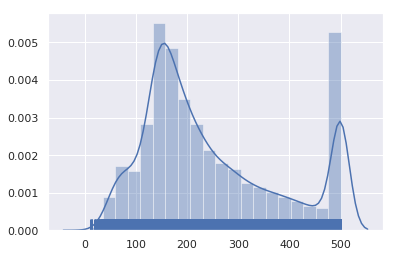

In [54]:
sns.distplot(train_data_lengths[:], bins=20, hist=True, rug=True)

In [107]:
from gluonnlp.data import batchify as bf
batcify_fn = bf.Tuple(bf.Pad(axis=0), bf.Stack())

In [108]:
a = ([1,2,3], 0)
b = ([4,5], 1)
c = ([6,7,8,9,10,11,12,13], 1)
batcify_fn([a,b,c])

(
 [[ 1  2  3  0  0  0  0  0]
  [ 4  5  0  0  0  0  0  0]
  [ 6  7  8  9 10 11 12 13]]
 <NDArray 3x8 @cpu_shared(0)>, 
 [0 1 1]
 <NDArray 3 @cpu_shared(0)>)

In [55]:
batch_sampler = nlp.data.sampler.FixedBucketSampler(train_data_lengths, 
                                                    batch_size=100, 
                                                    num_buckets=20, 
                                                    shuffle=True)

In [60]:
print(batch_sampler.stats())

FixedBucketSampler:
  sample_num=25000, batch_num=261
  key=[44, 68, 92, 116, 140, 164, 188, 212, 236, 260, 284, 308, 332, 356, 380, 404, 428, 452, 476, 500]
  cnt=[139, 842, 955, 1003, 2278, 3408, 2585, 2029, 1559, 1254, 1075, 925, 766, 645, 605, 524, 468, 376, 354, 3210]
  batch_size=[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


In [61]:
batch_sampler = nlp.data.sampler.FixedBucketSampler(train_data_lengths, 
                                                    batch_size=100, 
                                                    num_buckets=20, 
                                                    shuffle=True,
                                                    ratio=.5)
print(batch_sampler.stats())

FixedBucketSampler:
  sample_num=25000, batch_num=210
  key=[44, 68, 92, 116, 140, 164, 188, 212, 236, 260, 284, 308, 332, 356, 380, 404, 428, 452, 476, 500]
  cnt=[139, 842, 955, 1003, 2278, 3408, 2585, 2029, 1559, 1254, 1075, 925, 766, 645, 605, 524, 468, 376, 354, 3210]
  batch_size=[568, 367, 271, 215, 178, 152, 132, 117, 105, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


In [ ]:
train_data_loader = gluon.data.DataLoader(train_dataset, batch_sampler=batch_sampler, batchify_fn=batcify_fn)